In [1]:
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr
import random 
import os 
import pandas as pd 

from work import handler
from work import casestudy
from work import storm_tracker

from work.plots.hist import simple_hist

settings_path = 'settings/sam3d.yaml'

hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 1.96 seconds


In [2]:
duration_min = 6  # or 10
surfmaxkm2_min = 10000  # or other value
region_latmin, region_latmax, region_lonmin, region_lonmax = -15, 30, -180, 180
filename_save = f"profile_dataset_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, filename_save)
ds = xr.open_dataset(storms_path)
ds = ds.drop_isel(DCS_number = [353, 373, 374, 397, 398, 399, 426]) # TABS null at a certain altitude, not identified why
ds

<xarray.Dataset>
Dimensions:                   (DCS_number: 521, z: 52)
Coordinates:
  * DCS_number                (DCS_number) int64 153512 153524 ... 295399 297410
  * z                         (z) float32 20.0 61.2 ... 1.447e+04 1.497e+04
Data variables: (12/14)
    TABS_init_profile         (DCS_number, z) float64 ...
    QV_init_profile           (DCS_number, z) float64 ...
    U_init_profile            (DCS_number, z) float64 ...
    V_init_profile            (DCS_number, z) float64 ...
    TABS_max_instant_profile  (DCS_number, z) float64 ...
    QV_max_instant_profile    (DCS_number, z) float64 ...
    ...                        ...
    lon_init                  (DCS_number) float64 ...
    lat_init                  (DCS_number) float64 ...
    time_init                 (DCS_number) datetime64[ns] ...
    lon_max_instant           (DCS_number) float64 ...
    lat_max_instant           (DCS_number) float64 ...
    time_max_instant          (DCS_number) datetime64[ns] ...

# Data Processing


In [16]:
import numpy as np

def compute_direction_and_speed(lon1, lat1, lon2, lat2, time_diff_hours):
    R = 6371.0  # Earth's radius in kilometers
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    delta_lon = lon2 - lon1
    delta_lat = lat2 - lat1
    
    direction = np.arctan2(delta_lat, delta_lon)
    
    a = np.sin(delta_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance_km = R * c 
    
    speed =  distance_km / time_diff_hours
    
    return direction, 3.6*speed

def projection_on_propagation_direction(U, V, u_p, v_p):
    u_p = u_p[:, np.newaxis]
    v_p = v_p[:, np.newaxis]
    tangeant_wind = U * u_p + V * v_p
    normal_wind = - U * u_p + V * v_p
    return tangeant_wind, normal_wind

def moving_average(data, n, axis=1):
    # Move axis to the first position for easier processing
    data = np.moveaxis(data, axis, 0)
    
    # Apply moving average along the first axis
    shape = data.shape
    result = np.empty((shape[0] - n + 1,) + shape[1:])
    for idx in np.ndindex(*shape[1:]):  # Loop over all remaining dimensions
        result[(...,) + idx] = np.convolve(data[(...,) + idx], np.ones(n) / n, mode='valid')
    
    # Move the axis back to its original position
    result = np.moveaxis(result, 0, axis)

    return result[:,2:]

## Scale for each features*levels individually (works better)

In [17]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def scale_profiles_v2(ds, scaler=None):
    # Extract the profile data
    TABS_init_profile = ds['TABS_init_profile'].values
    QV_init_profile = ds['QV_init_profile'].values
    U_init_profile = ds['U_init_profile'].values
    V_init_profile = ds['V_init_profile'].values

    TABS_max_instant_profile = ds['TABS_max_instant_profile'].values
    QV_max_instant_profile = ds['QV_max_instant_profile'].values
    U_max_instant_profile = ds['U_max_instant_profile'].values
    V_max_instant_profile = ds['V_max_instant_profile'].values

    z_levels = ds.z.values
    # Compute wind shear for initial profiles
    delta_U_init = 1000*np.diff(U_init_profile, axis=1)/np.diff(z_levels) # (m/s)/km
    delta_V_init = 1000*np.diff(V_init_profile, axis=1)/np.diff(z_levels) # (m/s)/km
    shear_magnitude_init = np.sqrt(delta_U_init**2 + delta_V_init**2)
    shear_direction_init = np.arctan2(delta_V_init, delta_U_init)  # In radians

    # Compute wind shear for max instant profiles
    delta_U_max = 1000*np.diff(U_max_instant_profile, axis=1)/np.diff(z_levels) # (m/s)/km
    delta_V_max = 1000*np.diff(V_max_instant_profile, axis=1)/np.diff(z_levels) # (m/s)/km
    # shear_magnitude_max = np.sqrt(delta_U_max**2 + delta_V_max**2)
    # shear_direction_max = np.arctan2(delta_V_max, delta_U_max)  # In radians

    propagation_direction, propagation_speed = compute_direction_and_speed(
        ds['lon_init'].values, 
        ds['lat_init'].values, 
        ds['lon_max_instant'].values, 
        ds['lat_max_instant'].values, 
        (ds["time_max_instant"].values - ds["time_init"].values).astype(float)/2
    )

    u_p = np.cos(propagation_direction)
    v_p = np.sin(propagation_direction)

    wind_tangeant_init, wind_normal_init = projection_on_propagation_direction(U_init_profile, V_init_profile, u_p, v_p)
    wind_tangeant_max_instant, wind_normal_max_instant = projection_on_propagation_direction(U_max_instant_profile, V_max_instant_profile, u_p, v_p)
    shear_tangeant_init, shear_normal_init = projection_on_propagation_direction(delta_U_init, delta_V_init, u_p, v_p)
    shear_tangeant_max_instant, shear_normal_max_instant = projection_on_propagation_direction(delta_U_max, delta_V_max, u_p, v_p)

    # shear_magnitude_init_bis = np.sqrt(shear_tangeant_init**2 + shear_normal_init**2)
    # shear_magnitude_max_bis = np.sqrt(shear_tangeant_max_instant**2 + shear_normal_max_instant**2)

    # Add padding at the bottom layer to maintain the original number of levels
    pad_width = ((0, 0), (1, 0))  # Pad before the first vertical level
    shear_magnitude_init = np.pad(shear_magnitude_init, pad_width, mode='constant', constant_values=0)
    shear_direction_init = np.pad(shear_direction_init, pad_width, mode='constant', constant_values=0)
    # shear_magnitude_max = np.pad(shear_magnitude_max, pad_width, mode='constant', constant_values=0)
    # shear_direction_max = np.pad(shear_direction_max, pad_width, mode='constant', constant_values=0)

    shear_tangeant_init = np.pad(shear_tangeant_init, pad_width, mode='constant', constant_values=0)
    shear_normal_init = np.pad(shear_normal_init, pad_width, mode='constant', constant_values=0)
    shear_tangeant_max_instant = np.pad(shear_tangeant_max_instant, pad_width, mode='constant', constant_values=0)
    shear_normal_max_instant = np.pad(shear_normal_max_instant, pad_width, mode='constant', constant_values=0)

    # shear_magnitude_init_bis = np.pad(shear_magnitude_init_bis, pad_width, mode='constant', constant_values=0)
    # shear_magnitude_max_bis = np.pad(shear_magnitude_max_bis, pad_width, mode='constant', constant_values=0)
    
    profiles_init_stack = np.stack([
        TABS_init_profile[:,4:-2],
        QV_init_profile[:,4:-2],
        moving_average(wind_tangeant_init,3)[:,1:-1],
        moving_average(wind_normal_init, 3)[:,1:-1],
        moving_average(shear_tangeant_init, 5),
        moving_average(shear_normal_init, 5),
        # moving_average(shear_magnitude_init, 5),
        # shear_magnitude_init_bis, it works
    ], axis=2)

    profiles_max_stack = np.stack([
        TABS_max_instant_profile[:,4:-2],
        QV_max_instant_profile[:,4:-2],
        moving_average(wind_tangeant_max_instant, 3)[:,1:-1], 
        moving_average(wind_normal_max_instant, 3)[:,1:-1],
        moving_average(shear_tangeant_max_instant, 5), 
        moving_average(shear_normal_max_instant, 5),
        # moving_average(shear_magnitude_max, 5),
        # shear_magnitude_max_bis, it works
    ], axis=2)

    # Concatenate initial and max profiles
    X = np.concatenate([profiles_init_stack, profiles_max_stack], axis=2)
    num_samples, num_levels, num_features = X.shape

    # Reshape to 2D array for scaling
    X_reshaped = X.reshape(-1, num_features)

    # Initialize or use provided scaler
    if scaler is None:
        scaler_profiles = StandardScaler()
        X_scaled_reshaped = scaler_profiles.fit_transform(X_reshaped)
    else:
        scaler_profiles = scaler
        X_scaled_reshaped = scaler_profiles.transform(X_reshaped)

    X_scaled = X_scaled_reshaped.reshape(num_samples, num_levels, num_features)
    return X, X_scaled, scaler_profiles

# Now, use the updated function
X, X_scaled, scaler_profiles = scale_profiles_v2(ds)
num_samples, num_levels, num_features = X.shape

In [18]:
import joblib
path_scaler_save = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, 'scaler_profiles.joblib')
joblib.dump(scaler_profiles, path_scaler_save)

['/homedata/mcarenso/shear/SAM3d_Tropics/scaler_profiles.joblib']

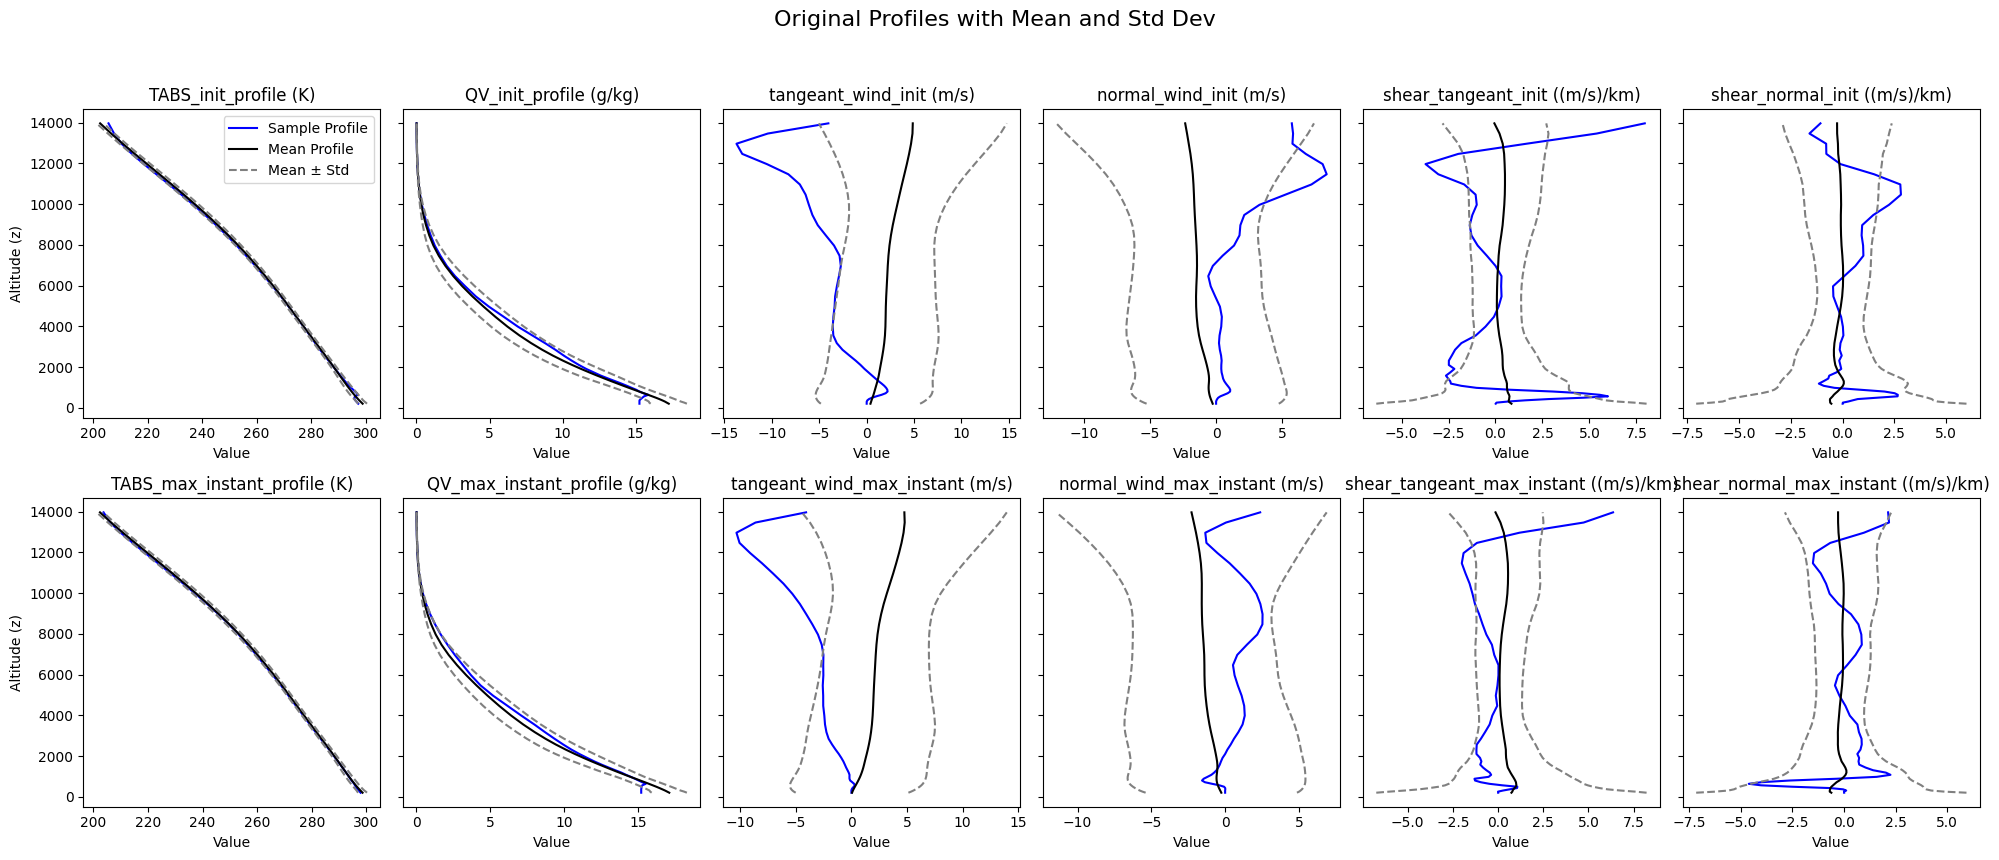

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import circmean, circstd


# Assuming 'ds' and 'X' are already defined in your environment
# 'X' has shape (num_samples, num_levels, num_features)

# Update the variable names to match the new variables
# variables = [
#     'TABS_init_profile', 'QV_init_profile', 'U_init_profile', 'V_init_profile','shear_magnitude_init', 'shear_direction_init',
#     'TABS_max_instant_profile', 'QV_max_instant_profile', 'U_max_instant_profile', 'V_max_instant_profile', 'shear_magnitude_max', 'shear_direction_max'
# ]

variables = [
    'TABS_init_profile', 'QV_init_profile', 'tangeant_wind_init', 'normal_wind_init', 'shear_tangeant_init', 'shear_normal_init', #'shear_magnitude_init', #'shear_magnitude_init_bis',
    'TABS_max_instant_profile', 'QV_max_instant_profile', 'tangeant_wind_max_instant', 'normal_wind_max_instant', 'shear_tangeant_max_instant', 'shear_normal_max_instant', #'shear_magnitude_max', #'shear_magnitude_max_bis'
]
units = [
    'K', 'g/kg', 'm/s', 'm/s', '(m/s)/km', '(m/s)/km',
    'K', 'g/kg', 'm/s', 'm/s', '(m/s)/km', '(m/s)/km'
]
num_samples, num_levels, num_features = X.shape

# Initialize arrays for mean and std dev profiles
mean_profiles = np.zeros((num_levels, num_features))
std_profiles = np.zeros((num_levels, num_features))

# Compute mean and std dev for each feature at each level over all samples
for i, var in enumerate(variables):
    if var in ['shear_direction_init', 'shear_direction_max']:
        # Use circular statistics for angular data
        mean_profiles[:, i] = np.degrees(circmean(np.radians(X[:, :, i]), high=np.pi, low=-np.pi, axis=0))
        std_profiles[:, i] = np.degrees(circstd(np.radians(X[:, :, i]), high=np.pi, low=-np.pi, axis=0))
    else:
        mean_profiles[:, i] = np.mean(X[:, :, i], axis=0)
        std_profiles[:, i] = np.std(X[:, :, i], axis=0)

# Split data into training and test sets (if needed)
indices = np.arange(num_samples)
X_train, X_test, idx_train, idx_test = train_test_split(
    X, indices, test_size=0.2, random_state=42
)

# Select a random sample from the test set
sample_index = np.random.choice(range(X_test.shape[0]))
ds_index = idx_test[sample_index]  # Index in the original dataset

# Extract the original data for the selected sample
original_sample = X_test[sample_index]  # Shape: (num_levels, num_features)

z_levels = ds['z'].values[4:-2]  # Vertical levels (assuming shape (num_levels,))

# Prepare to plot
n_cols = 6
fig, axes = plt.subplots(2, n_cols, figsize=(20, 9), sharey=True)
fig.suptitle('Original Profiles with Mean and Std Dev', fontsize=16)

for i, var, unit in zip(np.arange(len(variables)), variables, units):
    ax = axes[i // n_cols, i % n_cols]

    # Extract the profiles for each variable
    sample_profile = original_sample[:, i]
    mean_profile = mean_profiles[:, i]
    std_profile = std_profiles[:, i]

    # Handle wind shear direction (convert to degrees and wrap angles)
    if var in ['shear_direction_init', 'shear_direction_max']:
        sample_profile = np.degrees(np.arctan2(np.sin(np.radians(sample_profile)), np.cos(np.radians(sample_profile))))
        upper_std = (mean_profile + std_profile + 180) % 360 - 180
        lower_std = (mean_profile - std_profile + 180) % 360 - 180
    else:
        upper_std = mean_profile + std_profile
        lower_std = mean_profile - std_profile

    # Plot sample profile
    ax.plot(sample_profile, z_levels, label='Sample Profile', color='blue')

    # Plot mean profile
    ax.plot(mean_profile, z_levels, color='black', linestyle='-', label='Mean Profile')

    # Plot mean ± std dev profiles
    ax.plot(upper_std, z_levels, color='grey', linestyle='--', label='Mean ± Std' if i == 0 else "")
    ax.plot(lower_std, z_levels, color='grey', linestyle='--')

    ax.set_title(var+" ("+unit+")")
    ax.set_xlabel('Value')

    if i % n_cols == 0:
        ax.set_ylabel('Altitude (z)')
    ax.invert_yaxis()  # Invert y-axis if altitude increases with decreasing index

    if i == 0:
        ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Model Building #

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

2024-12-03 10:54:57.785998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 10:54:57.856690: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 10:54:57.877460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 10:54:58.001988: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 10:54:59.555067: W tensorflow/compiler/tf2

## CNNs Conv1D

In [8]:
latent_space_size = 32
model_name = "ae_conv1D_v0"+f"_latent_{latent_space_size}"

# Input layer
input_shape = (num_levels, num_features)  # Replace num_channels with the number of input channels
inputs = layers.Input(shape=input_shape)

# Encoder
encoded = layers.Conv1D(512, kernel_size=3, activation='relu', padding='same')(inputs)
# encoded = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(encoded)
# encoded = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(encoded)
attention_output = layers.Attention()([encoded, encoded])
flattened = layers.Flatten()(attention_output)
encoded = layers.Dense(64, activation='relu')(flattened)
# encoded = layers.Dense(32, activation='relu')(flattened)
bottleneck = layers.Dense(latent_space_size, activation='relu')(encoded)

# Decoder
# decoded = layers.Dense(32, activation='relu')(bottleneck)
decoded = layers.Dense(64, activation='relu')(bottleneck)
decoded = layers.Dense(52 * 32, activation='relu')(decoded)
decoded = layers.Reshape((52, 32))(decoded)
# decoded = layers.Conv1DTranspose(32, kernel_size=3, activation='relu', padding='same')(decoded)
# decoded = layers.Conv1DTranspose(128, kernel_size=3, activation='relu', padding='same')(decoded)
decoded = layers.Conv1DTranspose(512, kernel_size=3, activation='relu', padding='same')(decoded)
reconstructed_output = layers.Conv1DTranspose(input_shape[-1], kernel_size=3, activation='linear', padding='same')(decoded)

# Autoencoder model
autoencoder = models.Model(inputs, reconstructed_output, name = model_name)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "ae_conv1D_v0_latent_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 46, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 46, 512)   │     18,944 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 46, 512)   │          0 │ conv1d[0][0],     │
│ (Attention)         │                   │            │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 23552)     │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │  1,507,392 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      2,112 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1664)      │    108,160 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 52, 32)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose    │ (None, 52, 512)   │     49,664 │ reshape[0][0]     │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_1  │ (None, 52, 12)    │     18,444 │ conv1d_transpose… │
│ (Conv1DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,706,796 (6.51 MB)

 Trainable params: 1,706,796 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

## LSTM 

In [9]:
latent_space_size = 64
model_name = "ae_LSTM_v0"+f"_latent_{latent_space_size}"

# Input layer
input_shape = (num_levels, num_features)
inputs = layers.Input(shape=input_shape)

# Encoder
encoded = layers.LSTM(64, return_sequences=True)(inputs)
encoded = layers.LSTM(32)(encoded)
bottleneck = layers.Dense(latent_space_size, activation='relu')(encoded)

# Decoder
decoded = layers.RepeatVector(num_levels)(bottleneck)
decoded = layers.LSTM(32, return_sequences=True)(decoded)
decoded = layers.LSTM(64, return_sequences=True)(decoded)
reconstructed_output = layers.TimeDistributed(layers.Dense(num_features, activation='linear'))(decoded)

# Autoencoder model
autoencoder = models.Model(inputs, reconstructed_output, name = model_name)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "ae_LSTM_v0_latent_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 46, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 46, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 46, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 46, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 46, 12)         │           780 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,268 (282.30 KB)

 Trainable params: 72,268 (282.30 KB)

 Non-trainable params: 0 (0.00 B)

## Fully Connected

In [10]:
latent_space_size = 24
model_name = 'ae_fully_connected_v2'+f"_latent_{latent_space_size}"

# Input layer
input_shape = (num_levels, num_features)
inputs = layers.Input(shape=input_shape)

# Flatten the input
flattened_inputs = layers.Flatten()(inputs)

# Encoder
encoded = layers.Dense(512, activation='relu')(flattened_inputs)
encoded = layers.Dense(256, activation='relu')(flattened_inputs)
encoded = layers.Dense(128, activation='relu')(encoded)
encoded = layers.Dense(64, activation='relu')(encoded)
bottleneck = layers.Dense(latent_space_size, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(64, activation='relu')(bottleneck)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(256, activation='relu')(decoded)
decoded = layers.Dense(512, activation='relu')(decoded)
decoded = layers.Dense(num_levels * num_features, activation='linear')(decoded)

# Reshape the output
reconstructed_output = layers.Reshape((num_levels, num_features))(decoded)

def custom_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    smoothness_loss = tf.reduce_mean(tf.square(y_pred[:, 1:, :] - y_pred[:, :-1, :]))
    return mse_loss + smoothness_weight * smoothness_loss


# Autoencoder model
autoencoder = models.Model(inputs, reconstructed_output, name=model_name)
smoothness_weight = 5  # Adjust this hyperparameter
autoencoder.compile(optimizer='adam', loss=custom_loss)

autoencoder.summary()

Model: "ae_fully_connected_v2_latent_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 46, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 552)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       141,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 552)            │       283,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 46, 12)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641,984 (2.45 MB)

 Trainable params: 641,984 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [11]:
from sklearn.model_selection import train_test_split
 
print("Training buddy : ", model_name)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)


history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Training buddy :  ae_fully_connected_v2_latent_24
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.9195 - val_loss: 0.7398
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6552 - val_loss: 0.6049
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5000 - val_loss: 0.5374
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4333 - val_loss: 0.4677
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3987 - val_loss: 0.3999
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3420 - val_loss: 0.3744
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3353 - val_loss: 0.3575
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3288 - val_loss: 0.3488
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3110 - val_loss: 0.3429
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3096 - val_loss: 0.3426
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2995 - val_loss: 0.3394
Epoch 12/100

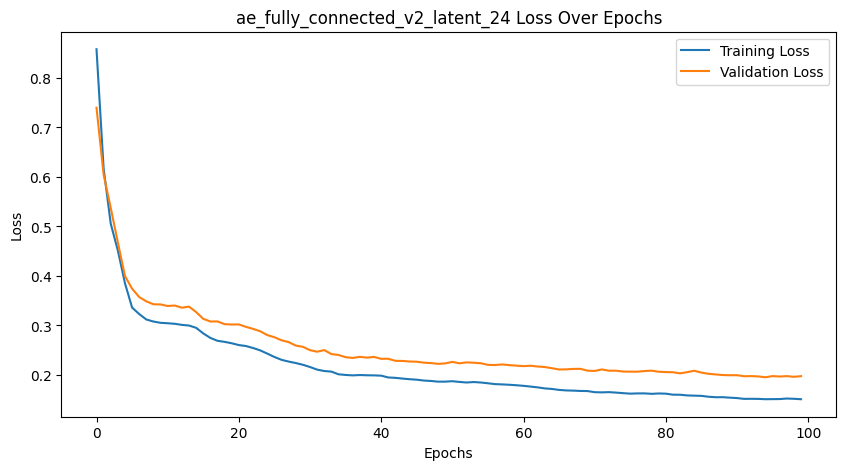

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{model_name} Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Encoder model
encoder = keras.Model(inputs=inputs, outputs=bottleneck)
encoded_data = encoder.predict(X_scaled)

ae_name = f'{model_name}_v0.keras'
save_path_ae = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, ae_name)
autoencoder.save(save_path_ae)
print("saved : ", ae_name)

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
saved :  ae_fully_connected_v2_latent_24_v0.keras


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


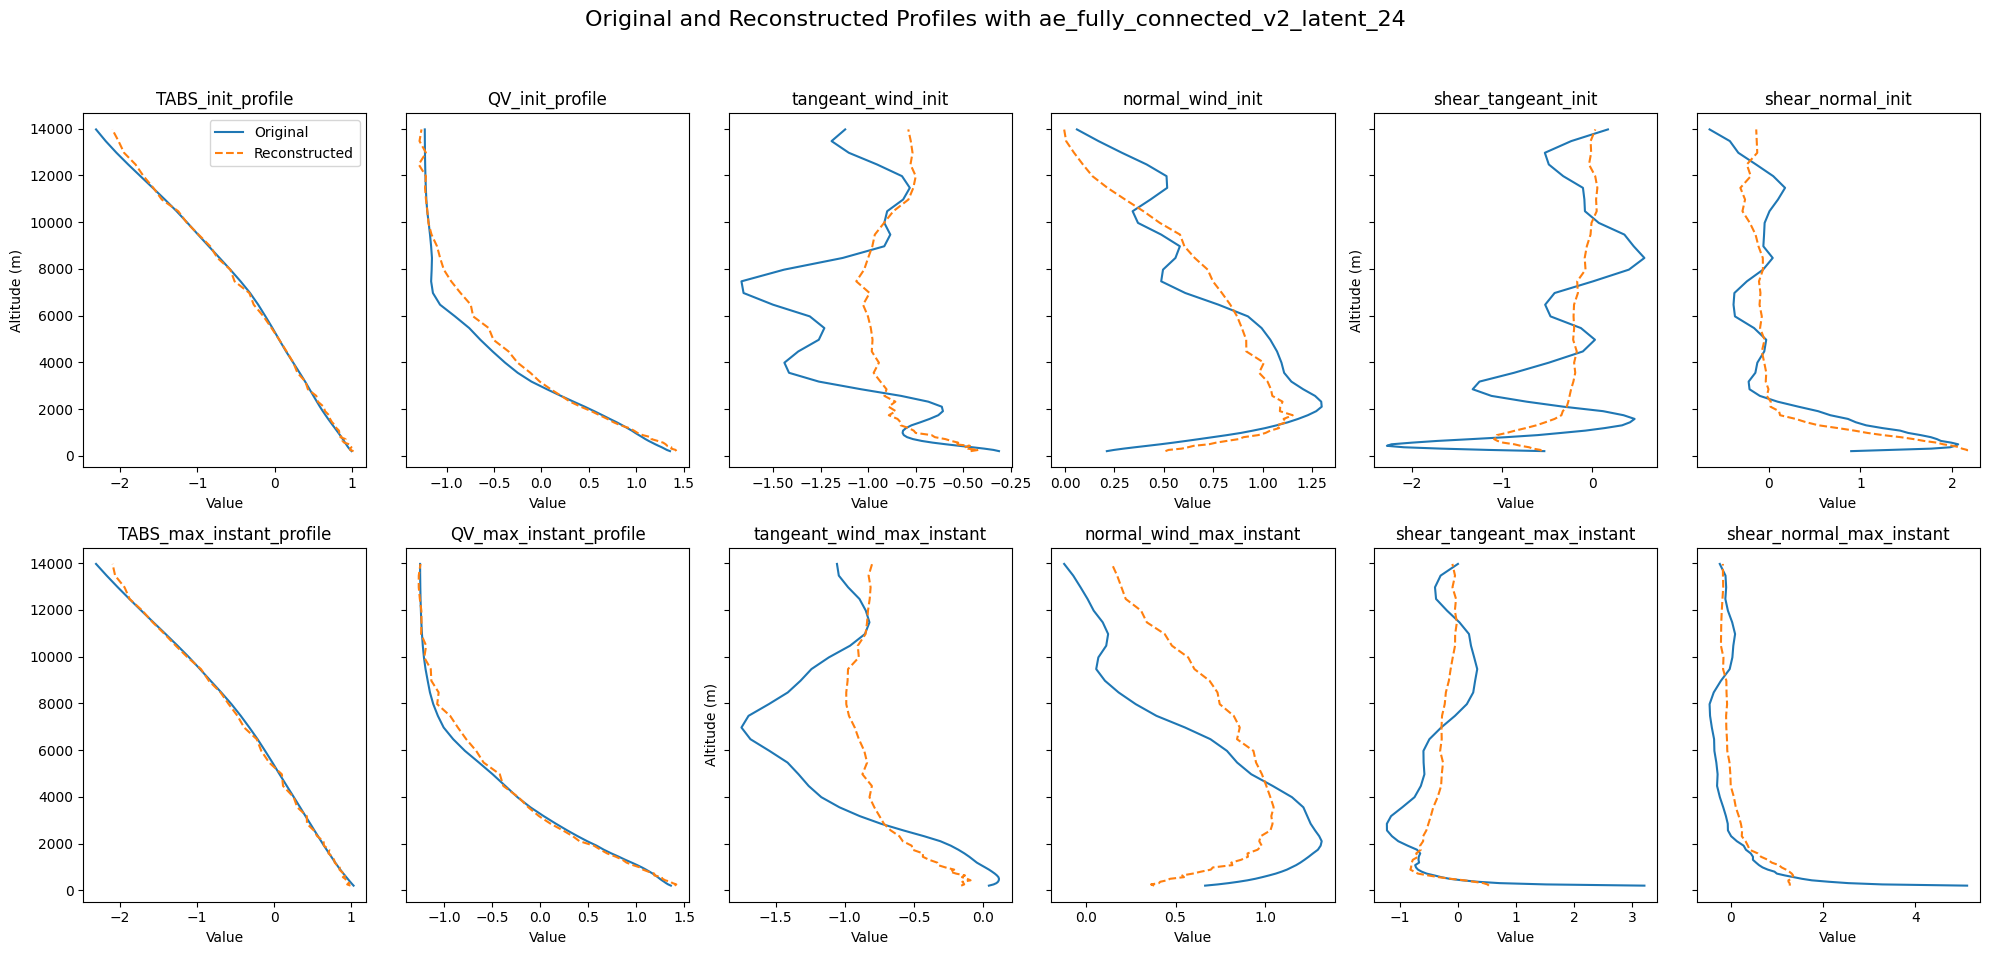

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Assuming 'ds', 'X_scaled', and 'autoencoder' are already defined

# # Variable names in the order they were concatenated
# variables = [
#     'TABS_init_profile', 'QV_init_profile', 'U_init_profile', 'V_init_profile',
#     'TABS_max_instant_profile', 'QV_max_instant_profile', 'U_max_instant_profile', 'V_max_instant_profile'
# ]

variables = [
    'TABS_init_profile', 'QV_init_profile', 'tangeant_wind_init', 'normal_wind_init', 'shear_tangeant_init', 'shear_normal_init', #'shear_magnitude_init', #'shear_magnitude_init_bis',
    'TABS_max_instant_profile', 'QV_max_instant_profile', 'tangeant_wind_max_instant', 'normal_wind_max_instant', 'shear_tangeant_max_instant', 'shear_normal_max_instant', #'shear_magnitude_max', #'shear_magnitude_max_bis'
]

indices = np.arange(num_samples)

# Perform train_test_split with indices to keep track
X_train, X_test, idx_train, idx_test = train_test_split(
    X_scaled, indices, test_size=0.2, random_state=42
)

# Reconstruct inputs using the trained autoencoder
reconstructed_data = autoencoder.predict(X_test)

sample_index = np.random.choice(range(X_test.shape[0]))
ds_index = idx_test[sample_index]  # Index in the original dataset

# Extract the original and reconstructed data for the selected samplerray([   20.   ,    61.2  ,   104.872,
original_sample = X_test[sample_index]           # Shape: (num_levels, num_features)
reconstructed_sample = reconstructed_data[sample_index]  # Shape: (num_levels, num_features)

z_levels = ds['z'].values[4:-2]  # Vertical levels

# Extract the profiles for each variable
original_profiles = {}
reconstructed_profiles = {}

for i, var in enumerate(variables):
    original_profiles[var] = original_sample[:, i]        # Shape: (num_levels,)
    reconstructed_profiles[var] = reconstructed_sample[:, i]  # Shape: (num_levels,)

# Plot profiles in subplots
n_cols = 6
fig, axes = plt.subplots(2, n_cols, figsize=(20, 10), sharey=True)
fig.suptitle('Original and Reconstructed Profiles with '+f"{model_name}", fontsize=16)

for i, var in enumerate(variables):
    ax = axes[i // n_cols, i % n_cols]
    # Plot original and reconstructed profiles
    ax.plot(original_profiles[var], z_levels, label='Original')
    ax.plot(reconstructed_profiles[var], z_levels, label='Reconstructed', linestyle='--')
    ax.set_title(var)
    ax.set_xlabel('Value')
    if i % 4 == 0:
        ax.set_ylabel('Altitude (m)')
    ax.invert_yaxis()  # Invert y-axis if your altitude increases with decreasing index
    if i == 0:
        ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt

n_worst = 5

# Reconstruct inputs using the trained autoencoder
reconstructed_data_scaled = autoencoder.predict(X_scaled)  # Shape: (num_samples, num_levels, num_features)

# Reshape the scaled data for inverse transformation
num_samples, num_levels, num_features = X_scaled.shape
X_scaled_reshaped = X_scaled.reshape(-1, num_features)
reconstructed_scaled_reshaped = reconstructed_data_scaled.reshape(-1, num_features)

# Inverse transform to get original units
X_unscaled_reshaped = scaler_profiles.inverse_transform(X_scaled_reshaped)
reconstructed_unscaled_reshaped = scaler_profiles.inverse_transform(reconstructed_scaled_reshaped)

# Reshape back to original shape
X_unscaled = X_unscaled_reshaped.reshape(num_samples, num_levels, num_features)
reconstructed_unscaled = reconstructed_unscaled_reshaped.reshape(num_samples, num_levels, num_features)

# Compute the MSE per sample over all variables and levels (on unscaled data)
mse_per_sample = np.mean((X_unscaled - reconstructed_unscaled)**2, axis=(1,2))  # Shape: (num_samples,)

# Find indices of the samples with the worst (highest) MSE
worst_indices = np.argsort(mse_per_sample)[-n_worst:]  # Indices of top 5 MSE samples
# worst_indices = np.argsort(mse_per_sample)[:n_worst]  # Indices of top 5 MSE samples

print("Indices of the 5 worst MSE samples overall:", worst_indices)

# Compute MSE per variable (profile) per sample (on unscaled data)
worst_indices_per_variable = {}

for i, var in enumerate(variables):
    mse_var = np.mean((X_unscaled[:,:,i] - reconstructed_unscaled[:,:,i])**2, axis=1)  # Shape: (num_samples,)
    worst_indices_var = np.argsort(mse_var)[-n_worst:]
    worst_indices_per_variable[var] = worst_indices_var
    print(f"Indices of the 5 worst MSE samples for variable '{var}':", worst_indices_var)

# Function to plot the profiles
def plot_sample(sample_index, X_data_unscaled, reconstructed_data_unscaled, variables, z_levels, ds_index=None, model_name="Model"):
    # Extract the original and reconstructed data for the selected sample
    original_sample = X_data_unscaled[sample_index]           # Shape: (num_levels, num_features)
    reconstructed_sample = reconstructed_data_unscaled[sample_index]  # Shape: (num_levels, num_features)
    
    # Extract the profiles for each variable
    original_profiles = {}
    reconstructed_profiles = {}
    
    for i, var in enumerate(variables):
        original_profiles[var] = original_sample[:, i]        # Shape: (num_levels,)
        reconstructed_profiles[var] = reconstructed_sample[:, i]  # Shape: (num_levels,)
    
    # Plot profiles in subplots
    n_cols = 6
    n_rows = int(np.ceil(len(variables)/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10), sharey=True)
    fig.suptitle('Original and Reconstructed Profiles with '+f"{model_name}", fontsize=16)
    
    axes = axes.flatten()
    for i, var in enumerate(variables):
        ax = axes[i]
        # Plot original and reconstructed profiles
        ax.plot(original_profiles[var], z_levels, label='Original')
        ax.plot(reconstructed_profiles[var], z_levels, label='Reconstructed', linestyle='--')
        ax.set_title(var)
        ax.set_xlabel('Value')
        if i % n_cols == 0:
            ax.set_ylabel('Altitude (m)')
        ax.invert_yaxis()  # Invert y-axis if your altitude increases with decreasing index
        if i == 0:
            ax.legend()
    
    # Hide any unused subplots
    for j in range(len(variables), n_rows * n_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot the profiles for the 5 worst samples overall
for idx in worst_indices:
    # print(f"\nPlotting sample with index {idx} (Overall Worst MSE)")
    # plot_sample(idx, X_unscaled, reconstructed_unscaled, variables, z_levels, ds_index=idx, model_name="Autoencoder")
    continue

# Optionally, plot the worst samples per variable
for var in variables:
    # print(f"\nPlotting worst samples for variable '{var}'")
    for idx in worst_indices_per_variable[var]:
        # print(f"Sample index {idx} (Worst MSE for {var})")
        # plot_sample(idx, X_unscaled, reconstructed_unscaled, variables, z_levels, ds_index=idx, model_name="Autoencoder")
        continue

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Indices of the 5 worst MSE samples overall: [315   2 166 424 250]
Indices of the 5 worst MSE samples for variable 'TABS_init_profile': [  2 171 166 424 250]
Indices of the 5 worst MSE samples for variable 'QV_init_profile': [494 487 250 473 424]
Indices of the 5 worst MSE samples for variable 'tangeant_wind_init': [ 76 358 509 428 250]
Indices of the 5 worst MSE samples for variable 'normal_wind_init': [414  52 250  11 509]
Indices of the 5 worst MSE samples for variable 'shear_tangeant_init': [513 470 224 375 250]
Indices of the 5 worst MSE samples for variable 'shear_normal_init': [381 375 315 467 250]
Indices of the 5 worst MSE samples for variable 'TABS_max_instant_profile': [171   2 166 424 250]
Indices of the 5 worst MSE samples for variable 'QV_max_instant_profile': [398 250 487 473 424]
Indices of the 5 worst MSE samples for variable 'tangeant_wind_max_instant': [315 102 428   2 250]
Indices of the 5 worst MSE samples for variable 'normal

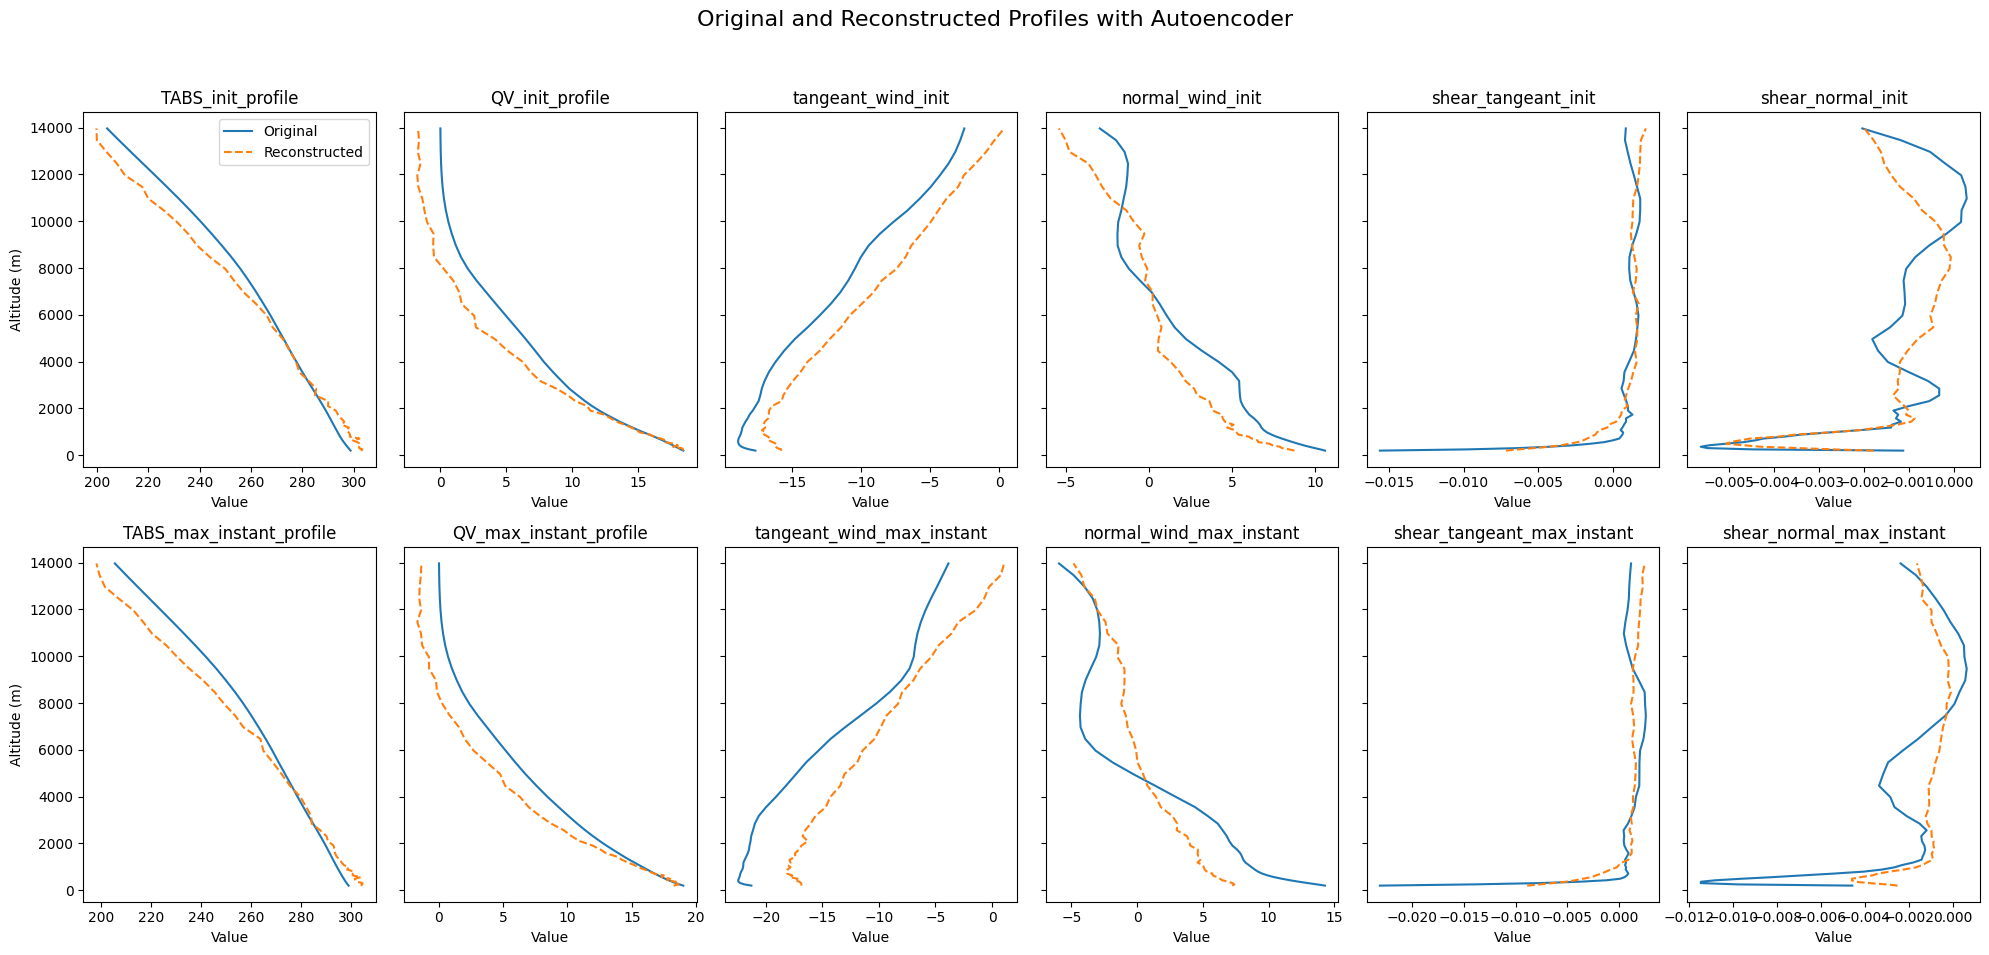

In [248]:
idx = 2
plot_sample(idx, X_unscaled, reconstructed_unscaled, variables, z_levels, ds_index=idx, model_name="Autoencoder")
